<a href="https://colab.research.google.com/github/umesh2908/LSTM-time-series-forecasting-of-AG-load/blob/master/LSTM_%26_GRU_Timeseriesforecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

#Importing dataset

In [2]:
from google.colab import files
uploaded = files.upload()

Saving forecast_data.xlsx to forecast_data.xlsx


In [25]:
import io
df=pd.read_excel(io.BytesIO(uploaded['forecast_data.xlsx']))

In [4]:
df.head()

,REGION_NAME,ZONE_NAME,CIRCLE_NAME,DIVISION_NAME,SUBDIVISION_NAME,FEEDER_BU,SUBSTATION_CODE,FEEDER_CODE,SUBSTATION_NAME,FEEDER_NAME,...,YPH_LCURR,BPH_LCURR,ACTIVE_ENERGY,KW,REACTIVE_ENERGY,APPERENT_ENERGY,ACTIVE_DEMAND,REACTIVE_DEMAND,APPERENT_DEMAND,FILE_SRC
0,KOKAN REGION,JALGAON ZONE,DHULE CIRCLE,DHULE RURAL DIVISION,PIMPALNER,582,94007,201,33/11 KV PIMPALNER,11 KV DEGAON,...,1.277,1.267,10.20,816.0,6.64,12.18,NaN,NaN,NaN,AMR
1,KOKAN REGION,JALGAON ZONE,DHULE CIRCLE,DHULE RURAL DIVISION,PIMPALNER,582,94007,201,33/11 KV PIMPALNER,11 KV DEGAON,...,1.341,1.328,10.76,860.8,7.13,12.91,NaN,NaN,NaN,AMR
2,KOKAN REGION,JALGAON ZONE,DHULE CIRCLE,DHULE RURAL DIVISION,PIMPALNER,582,94007,201,33/11 KV PIMPALNER,11 KV DEGAON,...,1.384,1.369,11.15,892.0,7.48,13.42,NaN,NaN,NaN,AMR
3,KOKAN REGION,JALGAON ZONE,DHULE CIRCLE,DHULE RURAL DIVISION,PIMPALNER,582,94007,201,33/11 KV PIMPALNER,11 KV DEGAON,...,1.396,1.380,11.24,899.2,7.58,13.55,NaN,NaN,NaN,AMR
4,KOKAN REGION,JALGAON ZONE,DHULE CIRCLE,DHULE RURAL DIVISION,PIMPALNER,582,94007,201,33/11 KV PIMPALNER,11 KV DEGAON,...,1.422,1.407,11.49,919.2,7.79,13.89,NaN,NaN,NaN,AMR


#Data Preprocessing

In [5]:
df['DAYPROFILE'] = pd.to_datetime(df.DAYPROFILE,format='%d-%m-%Y %H:%M:%S') 

<Figure size 720x360 with 0 Axes>

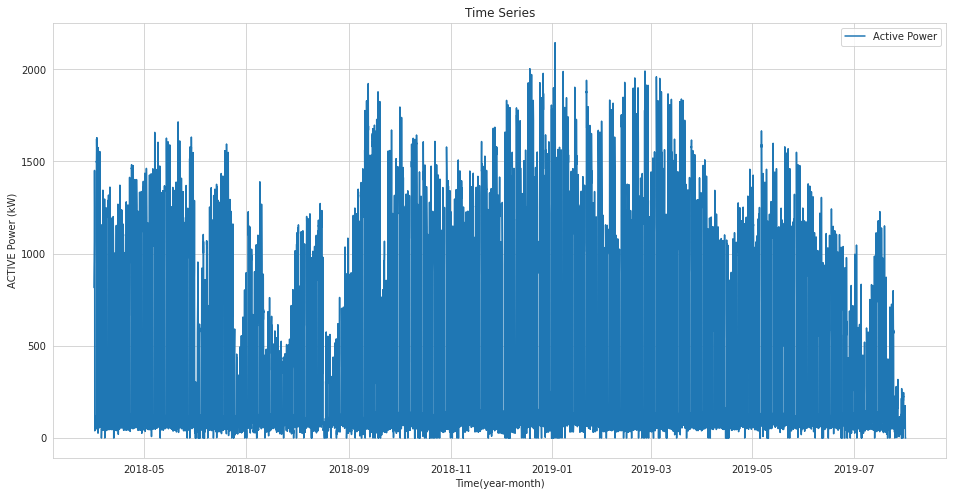

In [34]:
sns.set_style('whitegrid')
plt.figure(figsize=(10,5))
df.index = df['DAYPROFILE'] # indexing the Datetime to get the time period on the x-axis. 
ts = df['KW']
plt.figure(figsize=(16,8)) 
plt.plot(ts, label='Active Power') 
plt.title('Time Series') 
plt.xlabel("Time(year-month)") 
plt.ylabel("ACTIVE Power (kW)") 
plt.legend(loc='best')

In [35]:
train=pd.DataFrame({'Datetime':df['DAYPROFILE'],'ACTIVE_Power':df['KW']})

In [36]:
train.isnull().sum()

Datetime        0
ACTIVE_Power    0
dtype: int64

#Resampling of Time series data

In [37]:
train.Timestamp = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M') 
train.index = train.Timestamp 
# Hourly time series 
hourly = train.resample('H').mean() 
# Converting to daily mean 
daily = train.resample('D').mean() 
# Converting to weekly mean 
weekly = train.resample('W').mean() 
# Converting to monthly mean 
monthly = train.resample('M').mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


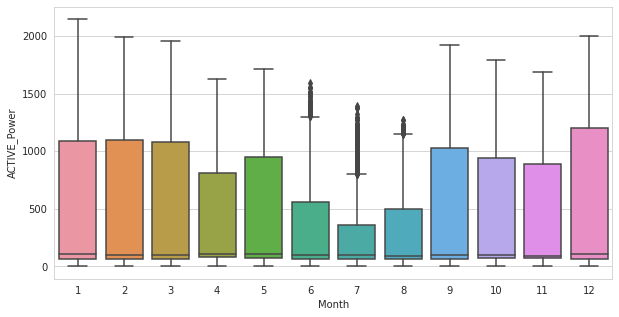

In [10]:
plt.figure(figsize=(10,5))
train['Year'] = train.index.year
train['Month'] = train.index.month
sns.boxplot(data=train,x='Month',y='ACTIVE_Power')

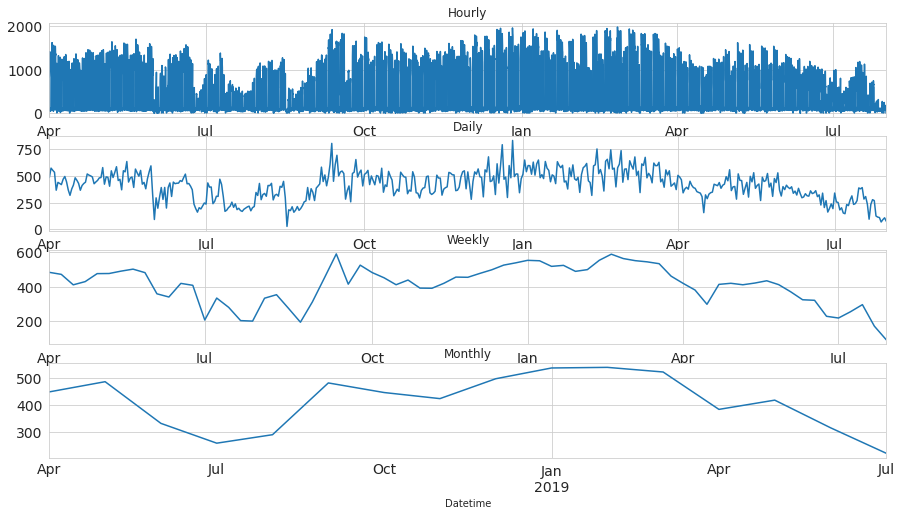

In [38]:
fig, axs = plt.subplots(4,1) 
hourly.ACTIVE_Power.plot(figsize=(15,8), title= 'Hourly', fontsize=14, ax=axs[0]) 
daily.ACTIVE_Power.plot(figsize=(15,8), title= 'Daily', fontsize=14, ax=axs[1]) 
weekly.ACTIVE_Power.plot(figsize=(15,8), title= 'Weekly', fontsize=14, ax=axs[2])
monthly.ACTIVE_Power.plot(figsize=(15,8), title= 'Monthly', fontsize=14, ax=axs[3]) 

In [39]:
train.shape

(23376, 2)

#Training and testing Split

In [40]:
Train=train.loc['01-04-2018':'30-06-2019'] 
valid=train.loc['07-01-2019':'07-31-2019']

In [41]:
Train.shape,valid.shape

((21888, 2), (1488, 2))

In [42]:
Train

,Datetime,ACTIVE_Power
Datetime,,
2018-04-01 00:00:00.000,2018-04-01 00:00:00.000,816.0
2018-04-01 00:30:00.000,2018-04-01 00:30:00.000,860.8
2018-04-01 01:00:00.000,2018-04-01 01:00:00.000,892.0
2018-04-01 01:30:00.000,2018-04-01 01:30:00.000,899.2
2018-04-01 02:00:00.000,2018-04-01 02:00:00.000,919.2
...,...,...
2019-06-30 21:30:00.001,2019-06-30 21:30:00.001,94.4
2019-06-30 22:00:00.001,2019-06-30 22:00:00.001,93.6
2019-06-30 22:30:00.001,2019-06-30 22:30:00.001,94.4


In [43]:
train_hourly = Train.resample('H').mean() 
Valid_hourly=valid.resample('H').mean()

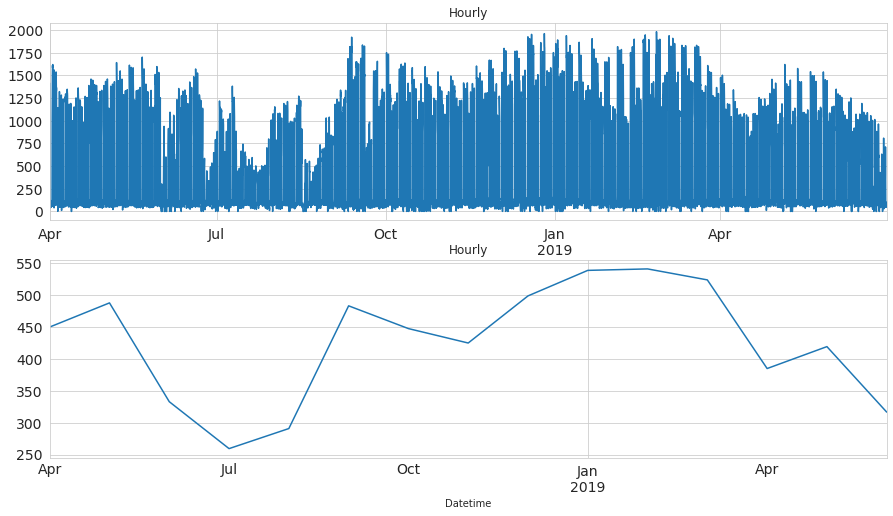

In [44]:
train_monthly = Train.resample('M').mean() 
fig, axs = plt.subplots(2,1) 
train_hourly.ACTIVE_Power.plot(figsize=(15,8), title= 'Hourly', fontsize=14, ax=axs[0]) 
train_monthly.ACTIVE_Power.plot(figsize=(15,8),title='Hourly', fontsize=14,ax=axs[1]) 

In [45]:

train_hourly

,ACTIVE_Power
Datetime,
2018-04-01 00:00:00,838.4
2018-04-01 01:00:00,895.6
2018-04-01 02:00:00,921.2
2018-04-01 03:00:00,941.2
2018-04-01 04:00:00,984.4
...,...
2019-06-30 19:00:00,95.6
2019-06-30 20:00:00,100.4
2019-06-30 21:00:00,94.4


In [46]:
Valid_hourly

,ACTIVE_Power
Datetime,
2019-07-01 00:00:00,87.6
2019-07-01 01:00:00,86.4
2019-07-01 02:00:00,88.4
2019-07-01 03:00:00,94.8
2019-07-01 04:00:00,113.6
...,...
2019-07-31 19:00:00,0.0
2019-07-31 20:00:00,0.0
2019-07-31 21:00:00,0.0


#Scaling of data 

In [47]:
train_hourly.shape, Valid_hourly.shape

((10944, 1), (744, 1))

In [48]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))

training_scaled = scaler.fit_transform(train_hourly)

In [49]:
training_scaled

array([[0.42292171],
       [0.45177563],
       [0.46468927],
       ...,
       [0.04761905],
       [0.04741727],
       [0.04539952]])

#LSTM & GRU Model Training

In [50]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout

In [51]:
features_set = []
labels = []
for i in range(48, 10944):
    features_set.append(training_scaled[i-48:i, 0])
    labels.append(training_scaled[i, 0])
np.random.seed(1)

In [52]:
features_set, labels = np.array(features_set), np.array(labels)
features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(features_set.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

#model.add(LSTM(units=30, return_sequences=True))
#model.add(Dropout(0.2))

model.add(LSTM(units=30))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')
history=model.fit(features_set, labels, epochs = 30, batch_size = 32,validation_split=0.1,  shuffle=False)


Epoch 1/30
307/307 [==============================] - 12s 13ms/step - loss: 0.0460 - val_loss: 0.0216
Epoch 2/30
307/307 [==============================] - 3s 10ms/step - loss: 0.0296 - val_loss: 0.0204
Epoch 3/30
307/307 [==============================] - 3s 10ms/step - loss: 0.0244 - val_loss: 0.0144
Epoch 4/30
307/307 [==============================] - 3s 10ms/step - loss: 0.0189 - val_loss: 0.0122
Epoch 5/30
307/307 [==============================] - 3s 10ms/step - loss: 0.0177 - val_loss: 0.0121
Epoch 6/30
307/307 [==============================] - 3s 10ms/step - loss: 0.0169 - val_loss: 0.0124
Epoch 7/30
307/307 [==============================] - 3s 10ms/step - loss: 0.0163 - val_loss: 0.0119
Epoch 8/30
307/307 [==============================] - 3s 10ms/step - loss: 0.0156 - val_loss: 0.0117
Epoch 9/30
307/307 [==============================] - 3s 10ms/step - loss: 0.0154 - val_loss: 0.0108
Epoch 10/30
307/307 [==============================] - 4s 12ms/step - loss: 0.0150 - val_l

In [53]:
features_set, labels = np.array(features_set), np.array(labels)
features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))
model_GRU = Sequential()
model_GRU.add(GRU(units=50, return_sequences=True, input_shape=(features_set.shape[1], 1)))
model_GRU.add(Dropout(0.2))

model_GRU.add(GRU(units=50, return_sequences=True))
model_GRU.add(Dropout(0.2))

#model_GRU.add(GRU(units=50, return_sequences=True))
#model_GRU.add(Dropout(0.2))

model_GRU.add(GRU(units=30))
model_GRU.add(Dropout(0.2))

model_GRU.add(Dense(units = 1))

model_GRU.compile(optimizer = 'adam', loss = 'mean_squared_error')
history_GRU=model_GRU.fit(features_set, labels, epochs = 30, batch_size = 32,validation_split=0.1,  shuffle=False)

Epoch 1/30
307/307 [==============================] - 8s 16ms/step - loss: 0.0294 - val_loss: 0.0113
Epoch 2/30
307/307 [==============================] - 4s 14ms/step - loss: 0.0189 - val_loss: 0.0116
Epoch 3/30
307/307 [==============================] - 3s 9ms/step - loss: 0.0177 - val_loss: 0.0112
Epoch 4/30
307/307 [==============================] - 3s 9ms/step - loss: 0.0169 - val_loss: 0.0114
Epoch 5/30
307/307 [==============================] - 3s 9ms/step - loss: 0.0163 - val_loss: 0.0110
Epoch 6/30
307/307 [==============================] - 3s 9ms/step - loss: 0.0158 - val_loss: 0.0105
Epoch 7/30
307/307 [==============================] - 3s 9ms/step - loss: 0.0155 - val_loss: 0.0104
Epoch 8/30
307/307 [==============================] - 3s 9ms/step - loss: 0.0154 - val_loss: 0.0105
Epoch 9/30
307/307 [==============================] - 3s 9ms/step - loss: 0.0151 - val_loss: 0.0106
Epoch 10/30
307/307 [==============================] - 3s 9ms/step - loss: 0.0150 - val_loss: 0.00

In [54]:
import matplotlib
matplotlib.rc('xtick', labelsize=15)     
matplotlib.rc('ytick', labelsize=15)

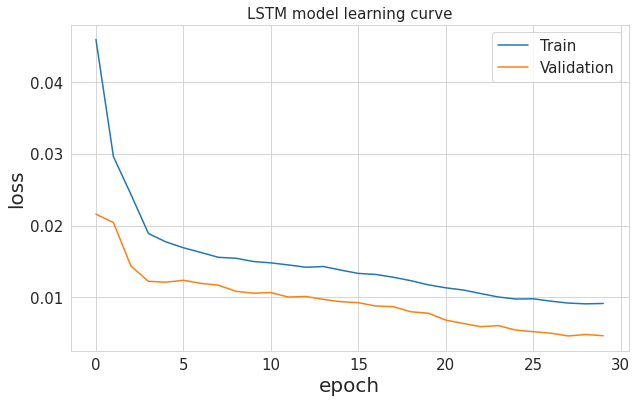

In [55]:
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'],label='Train')
plt.plot(history.history['val_loss'],label='Validation')
plt.xlabel('epoch',fontsize=20)
plt.ylabel('loss',fontsize=20)
plt.legend(fontsize=15)
plt.title('LSTM model learning curve',fontsize=15)
plt.savefig("LSTM learning.png",dpi=300, bbox_inches='tight')
plt.show()

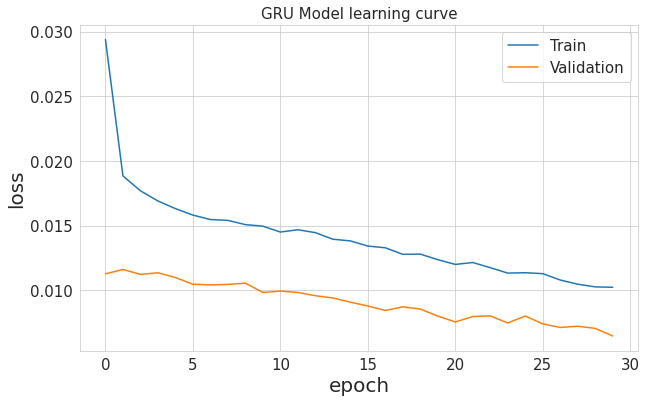

In [56]:
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.plot(history_GRU.history['loss'],label='Train')
plt.plot(history_GRU.history['val_loss'],label='Validation')
plt.xlabel('epoch',fontsize=20)
plt.ylabel('loss',fontsize=20)
plt.title("GRU Model learning curve", fontsize=15)
plt.legend(fontsize=15)
plt.savefig("GRU learning.png",dpi=300, bbox_inches='tight')
plt.show()

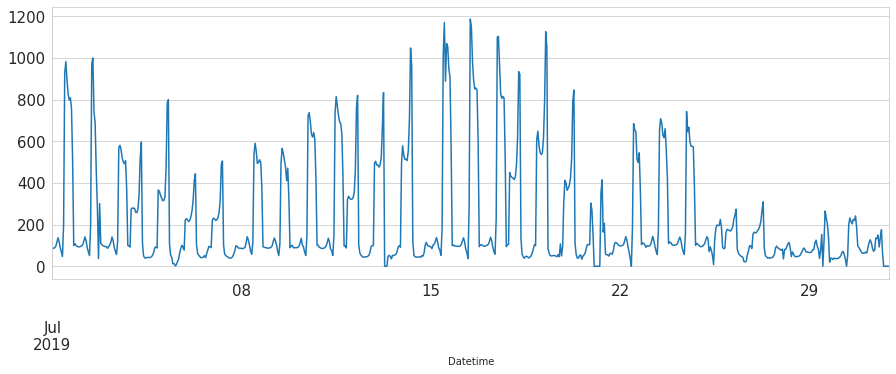

In [57]:
Valid_hourly['ACTIVE_Power'].plot(figsize=(15,5)) 

In [58]:
total = pd.concat((train_hourly['ACTIVE_Power'], Valid_hourly['ACTIVE_Power']), axis=0)

In [59]:
total.head()

Datetime
2018-04-01 00:00:00    838.4
2018-04-01 01:00:00    895.6
2018-04-01 02:00:00    921.2
2018-04-01 03:00:00    941.2
2018-04-01 04:00:00    984.4
Freq: H, Name: ACTIVE_Power, dtype: float64

In [60]:
test_inputs = total[len(total) - len(Valid_hourly) - 48:].values

In [61]:
test_inputs.shape

(792,)

In [62]:
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.fit_transform(test_inputs)

In [63]:
test_features = []
for i in range(48, 792):
    test_features.append(test_inputs[i-48:i, 0])

In [64]:
test_features = np.array(test_features)
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))

In [65]:
predictions = model.predict(test_features)

In [66]:
predictions = scaler.inverse_transform(predictions)

In [67]:
predictions.shape,Valid_hourly.shape

((744, 1), (744, 1))

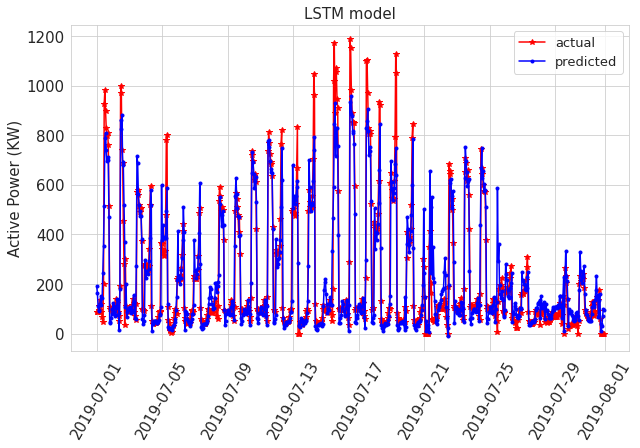

In [92]:
plt.figure(figsize=(10,6))
plt.plot(Valid_hourly.index,Valid_hourly['ACTIVE_Power'],color='red',marker='*',label='actual')
plt.plot(Valid_hourly.index,predictions, color='blue',marker='.', label='predicted')
plt.ylabel('Active Power (KW)',fontsize=15)
plt.xticks(rotation=60)
plt.title('LSTM model',fontsize=15)
plt.legend(fontsize=13)
plt.savefig("LSTM model forecasting.png",dpi=600, bbox_inches='tight')
plt.show()


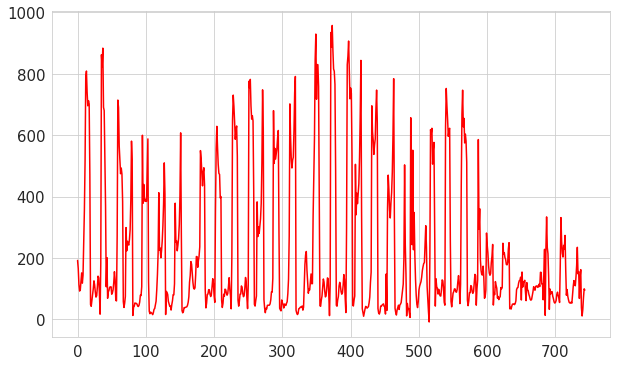

In [70]:
plt.figure(figsize=(10,6))
plt.plot(predictions , color='red', label='Predicted active power')

In [71]:
from sklearn.metrics import mean_squared_error
mse=mean_squared_error(Valid_hourly['ACTIVE_Power'],predictions)

In [72]:
RMSE=np.sqrt(mse)
print("RMSE:", RMSE)

RMSE: 98.33980179284043


In [73]:
Valid_hourly['ACTIVE_Power'][100:110]

Datetime
2019-07-05 04:00:00    332.8
2019-07-05 05:00:00    478.4
2019-07-05 06:00:00    782.0
2019-07-05 07:00:00    799.6
2019-07-05 08:00:00    108.4
2019-07-05 09:00:00     53.6
2019-07-05 10:00:00     42.8
2019-07-05 11:00:00     12.4
2019-07-05 12:00:00     13.2
2019-07-05 13:00:00      2.4
Freq: H, Name: ACTIVE_Power, dtype: float64

In [74]:
predictions[100:110]

array([[384.338   ],
       [384.23407 ],
       [494.4747  ],
       [587.7232  ],
       [121.757454],
       [ 26.248987],
       [ 18.258541],
       [ 23.405897],
       [ 21.243721],
       [ 19.34038 ]], dtype=float32)

In [75]:
from sklearn.metrics import r2_score
r2_score(Valid_hourly['ACTIVE_Power'],predictions)

0.8465247527380628

In [76]:
from sklearn.metrics import mean_absolute_error
MAE=mean_absolute_error(Valid_hourly['ACTIVE_Power'], predictions)
print('Mean absolute percentage error:', MAE/100)

Mean absolute percentage error: 0.5722869325619873


In [77]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 48, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 48, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 48, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 48, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 30)                9720      
                                                                 
 dropout_2 (Dropout)         (None, 30)                0         
                                                                 
 dense (Dense)               (None, 1)                 3

In [78]:
prediction_gru=model_GRU.predict(test_features)
prediction_gru = scaler.inverse_transform(prediction_gru)

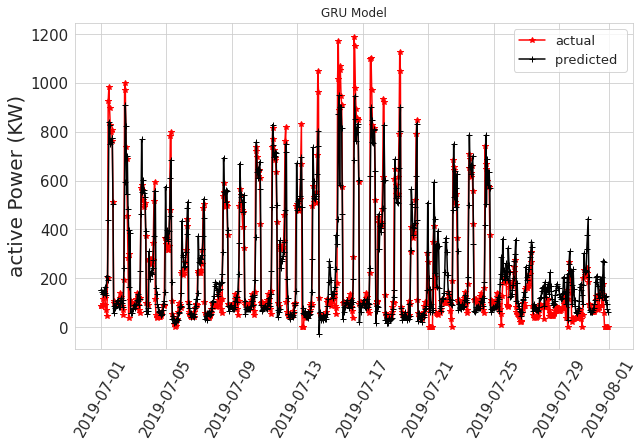

In [79]:
plt.figure(figsize=(10,6))
plt.plot(Valid_hourly.index,Valid_hourly['ACTIVE_Power'],color='red',marker='*',label='actual')
plt.plot(Valid_hourly.index,prediction_gru, color='black',marker='+', label='predicted ')
plt.ylabel('active Power (KW)',fontsize=20)
plt.xticks(rotation=60)
plt.title('GRU Model')
plt.legend(fontsize=13)
plt.savefig("GRU Model forecasting.png",dpi=300, bbox_inches='tight')
plt.show()

In [81]:
from sklearn.metrics import mean_squared_error
mse_gru=mean_squared_error(Valid_hourly['ACTIVE_Power'],prediction_gru)
print('RMES of GRU model forecast:',np.sqrt(mse_gru))

RMES of GRU model forecast: 109.68951874035761


In [82]:
from sklearn.metrics import r2_score
r2_score(Valid_hourly['ACTIVE_Power'],prediction_gru)

0.809054271933739

In [83]:
from sklearn.metrics import mean_absolute_error
MAE=mean_absolute_error(Valid_hourly['ACTIVE_Power'],prediction_gru)
print('MAPE of GRU model forecast:',MAE/100)

MAPE of GRU model forecast: 0.6651038528129618


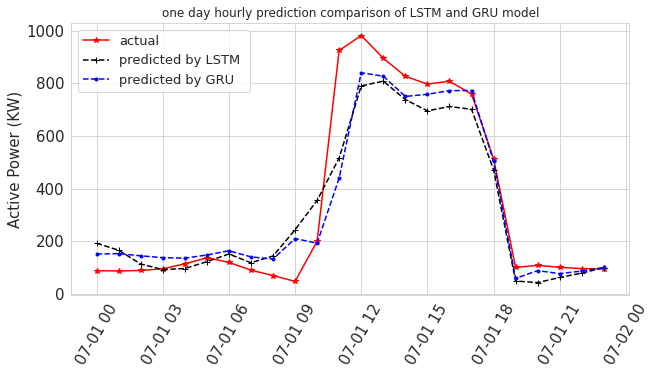

In [91]:
plt.figure(figsize=(10,5))
plt.plot(Valid_hourly.index[0:24],Valid_hourly['ACTIVE_Power'][0:24],color='red',marker='*',label='actual')
plt.plot(Valid_hourly.index[0:24],predictions[0:24], color='black',marker='+', label='predicted by LSTM ', linestyle='dashed')
plt.plot(Valid_hourly.index[0:24],prediction_gru[0:24], color='blue',marker='.', label='predicted by GRU ',linestyle='dashed')
plt.ylabel('Active Power (KW)',fontsize=15)
plt.xticks(rotation=60)
plt.title('one day hourly prediction comparison of LSTM and GRU model')
plt.legend(fontsize=13)
plt.savefig("LSTM vs GRU.png",dpi=300, bbox_inches='tight')
plt.show()

In [85]:
DL=pd.DataFrame({'A':[predictions]},Valid_hourly.index)
DL.to_excel("lstm_pred.xlsx")

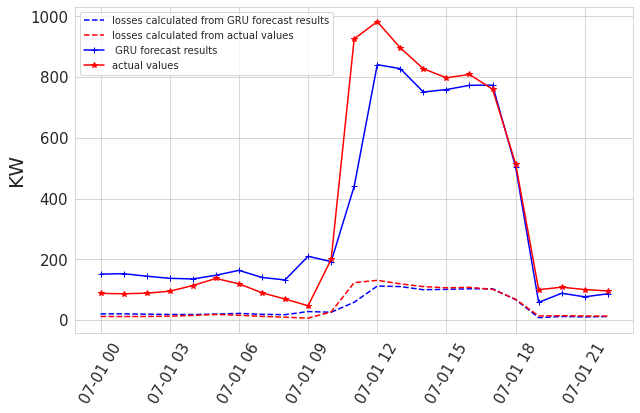

In [86]:
plt.figure(figsize=(10,6))
plt.plot(Valid_hourly.index[0:23],prediction_gru[0:23]*0.133,color="blue",label="losses calculated from GRU forecast results",linestyle='dashed')
plt.plot(Valid_hourly.index[0:23],Valid_hourly['ACTIVE_Power'][0:23]*0.133,color="red",label="losses calculated from actual values",linestyle='dashed')
plt.plot(Valid_hourly.index[0:23],prediction_gru[0:23],color="blue",label=" GRU forecast results",marker="+")
plt.plot(Valid_hourly.index[0:23],Valid_hourly['ACTIVE_Power'][0:23],color="red",label="actual values",marker="*")
plt.ylabel('KW',fontsize=20)
plt.xticks(rotation=60)
plt.legend(fontsize=10)

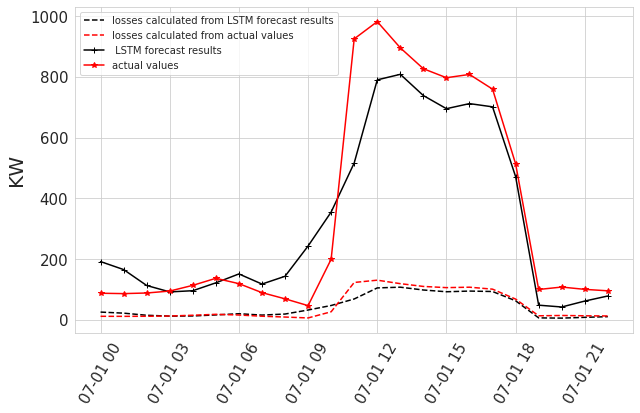

In [87]:
plt.figure(figsize=(10,6))
plt.plot(Valid_hourly.index[0:23],predictions[0:23]*0.133,color="black",label="losses calculated from LSTM forecast results",linestyle='dashed')
plt.plot(Valid_hourly.index[0:23],Valid_hourly['ACTIVE_Power'][0:23]*0.133,color="red",label="losses calculated from actual values",linestyle='dashed')
plt.plot(Valid_hourly.index[0:23],predictions[0:23],color="black",label=" LSTM forecast results",marker="+")
plt.plot(Valid_hourly.index[0:23],Valid_hourly['ACTIVE_Power'][0:23],color="red",label="actual values",marker="*")
plt.ylabel('KW',fontsize=20)
plt.xticks(rotation=60)
plt.legend()

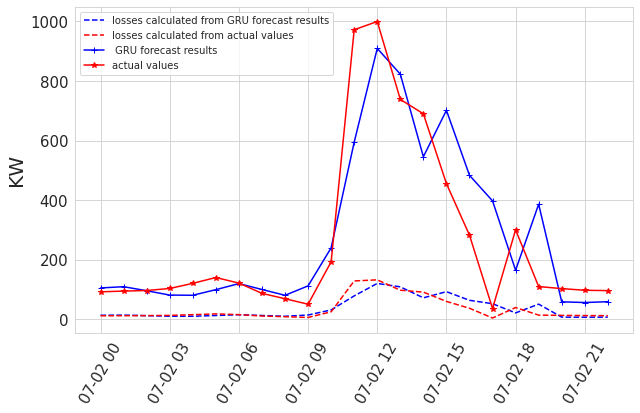

In [88]:
plt.figure(figsize=(10,6))
plt.plot(Valid_hourly.index[24:47],prediction_gru[24:47]*0.133,color="blue",label="losses calculated from GRU forecast results",linestyle='dashed')
plt.plot(Valid_hourly.index[24:47],Valid_hourly['ACTIVE_Power'][24:47]*0.133,color="red",label="losses calculated from actual values",linestyle='dashed')
plt.plot(Valid_hourly.index[24:47],prediction_gru[24:47],color="blue",label=" GRU forecast results",marker="+")
plt.plot(Valid_hourly.index[24:47],Valid_hourly['ACTIVE_Power'][24:47],color="red",label="actual values",marker="*")
plt.ylabel('KW',fontsize=20)
plt.xticks(rotation=60)
plt.legend()

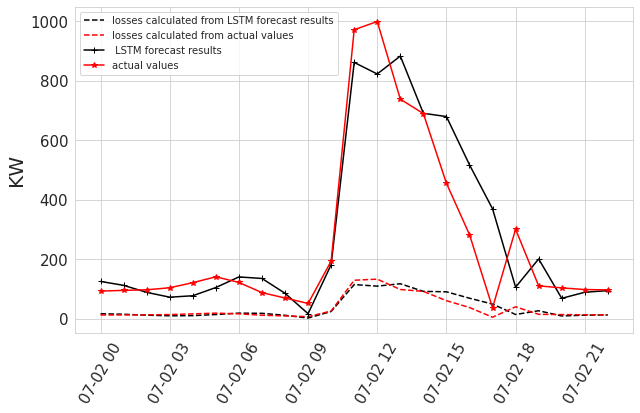

In [89]:
plt.figure(figsize=(10,6))
plt.plot(Valid_hourly.index[24:47],predictions[24:47]*0.133,color="black",label="losses calculated from LSTM forecast results",linestyle='dashed')
plt.plot(Valid_hourly.index[24:47],Valid_hourly['ACTIVE_Power'][24:47]*0.133,color="red",label="losses calculated from actual values",linestyle='dashed')
plt.plot(Valid_hourly.index[24:47],predictions[24:47],color="black",label=" LSTM forecast results",marker="+")
plt.plot(Valid_hourly.index[24:47],Valid_hourly['ACTIVE_Power'][24:47],color="red",label="actual values",marker="*")
plt.ylabel('KW',fontsize=20)
plt.xticks(rotation=60)
plt.legend()